In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import os.path
import astropy.constants as const
from scipy import integrate

In [27]:
class ColdDisc:
    def __init__(self, lmbd, Fnorm, d, i):
        self.lmbd = lmbd
        self.Fnorm = Fnorm
        self.d = d
        self.i = i

    def Blambda(self, T):
        return 2 * const.h.cgs.value * const.c.cgs.value**2 / self.lmbd**5 / (
        np.exp(const.h.cgs.value*const.c.cgs.value/(self.lmbd*const.k_B.cgs.value*T)) - 1
        )

    def I_lambda(self, Tcold):
        return self.Blambda(Tcold) * np.cos(self.i/180*np.pi) / self.d**2
    
    def F_lambda0(self, Rtid, Tcold):
        return np.pi*Rtid**2 * self.I_lambda(Tcold)

    def m_lambda0(self, *args, **kwargs):
        return -2.5 * np.log10( self.F_lambda0(*args, **kwargs) / self.Fnorm )
    
    def F_lambda_r(self, R, Tcold):
        return 2.*np.pi*R * self.I_lambda(Tcold)
    
    def F_lambda(self, Rs, Tfunc):
        f = lambda x: self.F_lambda_r(x, Tfunc(x))
        res, err = integrate.quad(f, *Rs)
        return res
    
    def m_lambda(self, *args, **kwargs):
        return -2.5 * np.log10( self.F_lambda(*args, **kwargs) / self.Fnorm )

In [3]:
# filename = '/Users/hombit/Dropbox/X-ray_novae_modeling (2) (1)/paper/images/ak_0.6_m8_1543-47/sum.dat'
filename = 'data/sum.dat'
model = np.genfromtxt(
    # Kerr 0.9
    #'/Users/hombit/Documents/projects/accretion/fred/data/F_1.9829e+38/alpha_0.64902/sum.dat',
    #'/Users/hombit/Documents/projects/accretion/fred/data/F_1.8954e+38/alpha_0.88938/sum.dat',
    #'/Users/hombit/Documents/projects/accretion/fred/data/F_1.8485e+38/alpha_0.99979/sum.dat',
    #'/Users/hombit/Documents/projects/accretion/fred/data/F_1.7979e+38/alpha_1.27575/sum.dat',
    #'/Users/hombit/Documents/projects/accretion/fred/data/F_1.7347e+38/alpha_1.4379/sum.dat',
    # Kerr 0.9, Tph=8000
    #'/Users/hombit/Documents/projects/accretion/fred/data/F_9.8653e+37/alpha_0.99589/sum.dat',
    # Kerr 0.6
    #'/Users/hombit/Documents/projects/accretion/fred/data/F_2.5947e+38/alpha_0.82624/sum.dat',
    filename,
    names=True
)
obsB = np.genfromtxt(
    '/Users/hombit/Dropbox/X-ray_novae_modeling (2) (1)/data_and_plots/opt/f1_B.txt',
    names=['t','mB'],
    delimiter=', '
)
obsV = np.genfromtxt(
    '/Users/hombit/Dropbox/X-ray_novae_modeling (2) (1)/data_and_plots/opt/f1_Vall.txt',
    names=['t','mV'],
    delimiter=', '
)

obsV_err = 0.06

# model['t'] -= 4.88
obsB['t'] -= 52446
obsV['t'] -= 52446
cut_t = -3

AV = 1.6
AB = 1.324 * 1.6

model['mV'] += AV 
model['mB'] += AB
# obsV['mV'] -= AV
# obsB['mB'] -= AB

16.42398


<IPython.core.display.Javascript object>


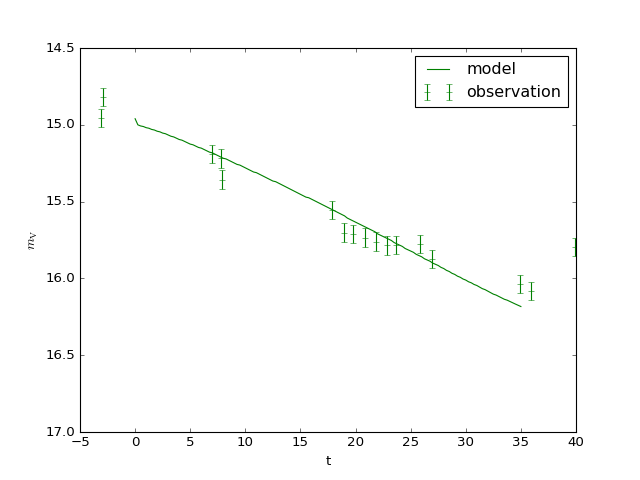

In [34]:
cd = ColdDisc(lmbd=5500*1e-8, Fnorm=3.75e-9/1e-8,
             d=8618.845*const.pc.cgs.value, i=20.7)
# mV_cold0 = cd.m_lambda0(Rtid=2.85421e+11, Tcold=6.3e3) + AV
# mV_cold = -2.5 * np.log10( 1 - (model['Rhot2Rout']-1e-9)**2. ) + mV_cold0

mV_cold = np.hstack((
        cd.m_lambda(
            [Rhot2Rout*2.85421e+11, 2.85421e+11], lambda x: 1e4 * (Rhot2Rout*2.85421e+11/x)**0.5
        ) for Rhot2Rout in model['Rhot2Rout']-1e-9
    )) + AV
mB_cold = -2.5 * np.log10( 1 - (model['Rhot2Rout']-1e-9)**2. ) + 10000

backgroundV = obsV['mV'][ obsV['t'] < -50 ].mean()
print(backgroundV)
# backgroundB = obsB['mB'][ obsB['t'] < -50 ].mean()
# http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/A%2bA/469/807/lmxb
backgroundB = 17.5

mV_sum = -2.5 * np.log10(
    + np.power(10., -0.4 * model['mV'])
    + np.power(10., -0.4 * mV_cold)
    + np.power(10., -0.4 * backgroundV)
)
mB_sum = -2.5 * np.log10(
    + np.power(10., -0.4 * model['mB'])
    + np.power(10., -0.4 * mB_cold)
    + np.power(10., -0.4 * backgroundB)
)

plt.gca().invert_yaxis()
plt.xlabel('t')
plt.ylabel(r'$m_\mathrm{V}$')
# plt.ylim([14.5,13.])
plt.xlim([-5,40])
plt.plot( model['t'][ model['t'] > cut_t ], mV_sum[ model['t'] > cut_t ], 'g-', label='model' )
plt.errorbar( obsV['t'], obsV['mV'], fmt='g+', yerr=obsV_err, label='observation' )
#plt.plot( model['t'][ model['t'] > cut_t ], mB_sum[ model['t'] > cut_t ], 'b-' )
#plt.plot( obsB['t'], obsB['mB'], 'b+' )
plt.legend(loc='best')

plt.savefig( os.path.join( os.path.dirname(filename), 'opt.eps') )